In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

In [2]:
gps = pd.read_csv('data/gps_clean.csv')

C:\Users\aziz\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
gps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1899557 entries, 0 to 1899556
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   vehicle_id      int64  
 1   line_id         int64  
 2   arrival_time    object 
 3   departure_time  object 
 4   station_id      int64  
 5   vehicle_type    float64
 6   stop_time       float64
 7   sequence_id     object 
 8   order           int64  
 9   line_label      object 
 10  travel_time     float64
 11  outlier         int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 173.9+ MB


In [4]:
#drop outliers
gps = gps[gps.outlier == 0]
gps.shape

(1850106, 12)

In [5]:
gps.arrival_time = gps.arrival_time.apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
gps.departure_time = gps.departure_time.apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [6]:
gps = gps.rename({'sequence_id':'TripID'}, axis=1)

In [7]:
gps.head()

,vehicle_id,line_id,arrival_time,departure_time,station_id,vehicle_type,stop_time,TripID,order,line_label,travel_time,outlier
0,41,3,2020-02-17 14:37:51,2020-02-17 14:38:13,10,2.0,22.0,41.0_0,5,5,148.0,0
1,41,3,2020-02-17 14:40:19,2020-02-17 14:40:32,9,2.0,13.0,41.0_0,6,5,149.0,0
2,41,3,2020-02-17 14:42:48,2020-02-17 14:42:48,8,2.0,0.0,41.0_0,7,5,129.0,0
3,41,3,2020-02-17 14:44:57,2020-02-17 14:45:02,7,2.0,5.0,41.0_0,8,5,79.0,0
4,41,3,2020-02-17 14:46:16,2020-02-17 14:46:34,6,2.0,18.0,41.0_0,9,5,137.0,0


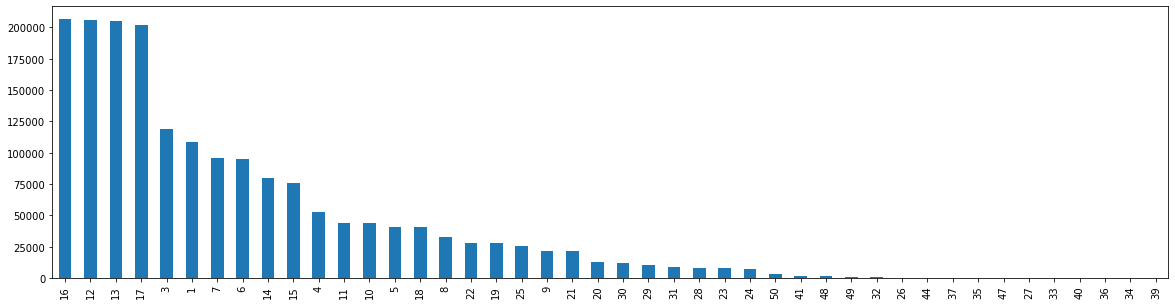

In [8]:
plt.figure(figsize=(20,5))
gps.line_id.value_counts().plot(kind = 'bar');

In [9]:
gps.shape

(1850106, 12)

# Timetable

In [10]:
stations_paths = pd.read_csv('data/stations_paths.csv')
stations_paths.tag.astype(int);

In [11]:
def increment_time(*x):
    if np.isnan(x[-2]):
        return logtime['logreg'][0] + timedelta(0,logtime['logreg'][1])
    else:
        if x[-3] != 1 :
            time = logtime['logreg'][0] + timedelta(0,logtime['logreg'][1])
            logtime['logreg'][0] = time
            total_inc = x[-1] + x[-2]
            logtime['logreg'][1] = total_inc
            return time
        else :
            total_inc = x[-1] + x[-2]
            logtime['logreg'] =  [x[1], total_inc]
            return  logtime['logreg'][0]

## TGM

In [12]:
horaires_tgm = pd.read_csv('../database/marche-horaire-tgm.csv', sep=';', encoding = 'ISO-8859-1')

In [13]:
horaires_tgm.drop(['sens ','Unnamed: 5','Unnamed: 6'], axis=1, inplace=True)
horaires_tgm = horaires_tgm.rename({'Sens ':'tag',  'ligne TGM (Tunis Marine vers Marsa )':'line_label', 'horaires (du Lundi à samedi)':'horaires'},axis=1)
horaires_tgm.drop('horaires (dimanche)',axis = 1, inplace = True)
horaires_tgm.tag = horaires_tgm.tag.apply(lambda x : 0 if x =='aller' else 1)
horaires_tgm.head()

,line_label,horaires,tag
0,TGM,03:30:00,0
1,TGM,04:18:00,0
2,TGM,05:00:00,0
3,TGM,05:24:00,0
4,TGM,05:42:00,0


In [14]:
horaires_tgm = horaires_tgm.merge(stations_paths[['line_id','tag','line_label']].groupby('line_id', as_index=False).first(), on  = ['line_label','tag'] ) 

In [15]:
#repeat lines to match number of stations for each path
train = pd.DataFrame(columns=horaires_tgm.columns)
for line_id in horaires_tgm.line_id.unique():
    nb_stations = stations_paths.query('line_id == '+str(line_id)).shape[0]
    train = train.append(horaires_tgm.loc[horaires_tgm[horaires_tgm.line_id == line_id].index.repeat(nb_stations)])

In [16]:
#increment order with respect to number of stations for each lines
train['order'] = train.groupby(['line_id','horaires']).cumcount()+1

In [17]:
#get the median time for each 2 consecutive stations in each line
line_ids = train.line_id.unique()
#here
traveltime_group = gps[(gps.line_id.isin(line_ids))].groupby(['line_id','order'],as_index=True).travel_time.median()
stoptime_group = gps[(gps.line_id.isin(line_ids))].groupby(['line_id','order'],as_index=True).stop_time.median()

In [18]:
train = train.merge(traveltime_group, on=['line_id','order'], how='left')
train = train.merge(stoptime_group, on=['line_id','order'], how='left')
train

,line_label,horaires,tag,line_id,order,travel_time,stop_time
0,TGM,03:30:00,0,10,1,1046.0,361.0
1,TGM,03:30:00,0,10,2,114.0,15.0
2,TGM,03:30:00,0,10,3,68.0,16.0
3,TGM,03:30:00,0,10,4,85.0,17.0
4,TGM,03:30:00,0,10,5,54.0,16.0
...,...,...,...,...,...,...,...
2335,TGM,00:15:00,1,11,14,87.0,45.0
2336,TGM,00:15:00,1,11,15,71.0,44.0
2337,TGM,00:15:00,1,11,16,119.0,48.0
2338,TGM,00:15:00,1,11,17,906.0,40.0


In [19]:
train.horaires = train.horaires.apply(lambda x : datetime.strptime('2000-1-1'+' '+x, '%Y-%m-%d %H:%M:%S'))

In [20]:
#increment time between stations
logtime = dict()
train.horaires = train.apply(lambda x : increment_time(*x), axis=1).dt.time

In [21]:
#add station coordinates
train = train.merge(stations_paths[['line_id','order','station_id','latitude','longitude']], on=['line_id','order'])

In [22]:
#add Trip Number
train = train.sort_values(['line_id','order'])
train['TripNb'] = train.groupby(['line_id','order']).cumcount()+1

In [23]:
def add_departure_time(*x):
    departure_time =  datetime(year = 2021, month = 1, day = 1, hour = x[0].hour, minute = x[0].minute, second = x[0].second) + timedelta(seconds=x[1])
    return departure_time.time()

In [24]:
train['departure_time'] = train[['horaires','stop_time']].apply(lambda x : add_departure_time(*x), axis=1)
train.rename({'horaires':'arrival_time'}, axis=1, inplace=True)

In [25]:
#sort values and remove microseconds
train.arrival_time = train.arrival_time.apply(lambda x : x.replace(x.hour,x.minute,x.second,0))
train.departure_time = train.departure_time.apply(lambda x : x.replace(x.hour,x.minute,x.second,0))

train = train.sort_values(['line_id', 'TripNb']).reset_index(drop = True)
train.head()

,line_label,arrival_time,tag,line_id,order,travel_time,stop_time,station_id,latitude,longitude,TripNb,departure_time
0,TGM,03:30:00,0,10,1,1046.0,361.0,72,36.800742,10.192478,1,03:36:01
1,TGM,03:53:27,0,10,2,114.0,15.0,73,36.814178,10.292450,1,03:53:42
2,TGM,03:55:36,0,10,3,68.0,16.0,74,36.818051,10.301940,1,03:55:52
3,TGM,03:57:00,0,10,4,85.0,17.0,75,36.819845,10.305601,1,03:57:17
4,TGM,03:58:42,0,10,5,54.0,16.0,76,36.824201,10.308773,1,03:58:58


<AxesSubplot:xlabel='latitude', ylabel='longitude'>

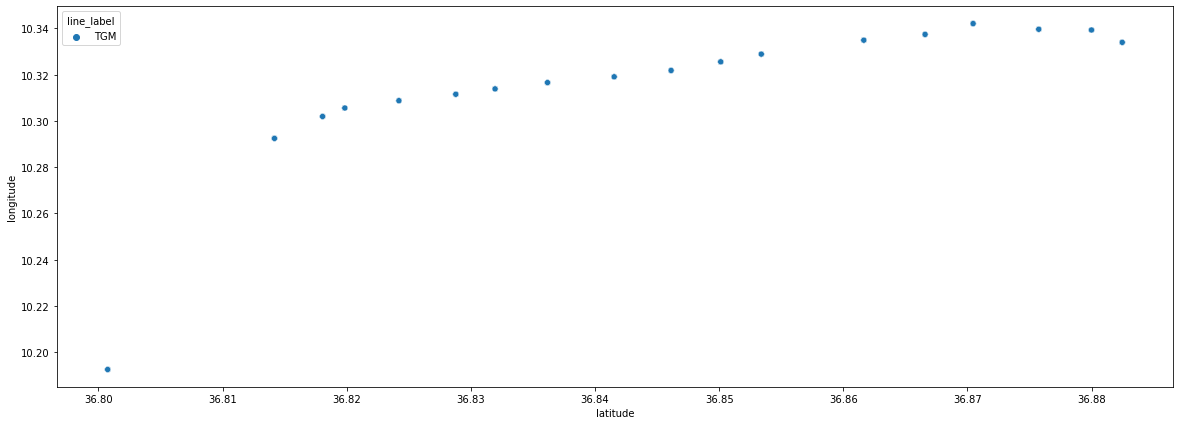

In [26]:
plt.figure(figsize= (20,7))
sns.scatterplot(data = train.drop(['arrival_time','TripNb'], axis=1).drop_duplicates(), x='latitude', y='longitude', hue = 'line_label')

## Metro

In [27]:
horaires_metro = pd.read_csv('../database/marche-horaire-lignes-metro.csv', sep=';', encoding = 'ISO-8859-1')

In [28]:
horaires_metro = horaires_metro[['ligne 1 (TGM vers Ben Arous)','horaires (du Lundi à samedi)','Sens ','horaires (dimanche)']].rename({'Sens ':'tag'},axis=1)
horaires_metro.head()

,ligne 1 (TGM vers Ben Arous),horaires (du Lundi à samedi),tag,horaires (dimanche)
0,ligne 1,03:58,aller,03:52
1,ligne 1,04:30,aller,04:25
2,ligne 1,05:00,aller,05:09
3,ligne 1,05:15,aller,05:26
4,ligne 1,05:32,aller,05:43


In [29]:
horaires_metro.drop('horaires (dimanche)', axis=1, inplace=True)
horaires_metro.tag = horaires_metro.tag.apply(lambda x : 1 if 'retour' in x else 0)
horaires_metro.rename({'ligne 1 (TGM vers Ben Arous)':'line_label', 'horaires (du Lundi à samedi)':'horaires' } , axis = 1, inplace=True)
horaires_metro.line_label = horaires_metro.line_label.str.split(' ').apply(lambda x : x[-1])

In [30]:
stations_paths.columns

Index(['latitude', 'longitude', 'station_id', 'line_id', 'order',
       'english_name', 'french_name', 'arabic_name', 'path_id', 'line_label',
       'tag', 'vehicle_type'],
      dtype='object')

In [31]:
horaires_metro.horaires = horaires_metro.horaires+':00'

In [32]:
horaires_metro.head()

,line_label,horaires,tag
0,1,03:58:00,0
1,1,04:30:00,0
2,1,05:00:00,0
3,1,05:15:00,0
4,1,05:32:00,0


In [33]:
#match line_label and tag with scheduled Trips
horaires_metro = horaires_metro.merge(stations_paths[['line_id','tag','line_label']].groupby('line_id', as_index=False).first(), on  =['line_label','tag'] ) 

In [34]:
#repeat lines to match number of stations for each path
metro = pd.DataFrame(columns=horaires_metro.columns)
for line_id in horaires_metro.line_id.unique():
    nb_stations = stations_paths.query('line_id == '+str(line_id)).shape[0]
    metro = metro.append(horaires_metro.loc[horaires_metro[horaires_metro.line_id == line_id].index.repeat(nb_stations)])

In [35]:
#increment order with respect to number of stations for each lines
metro['order'] = metro.groupby(['line_id','horaires']).cumcount()+1

In [36]:
#get the median time for each 2 consecutive stations in each line
line_ids = metro.line_id.unique()
#here
deltatime_group = gps[(gps.line_id.isin(line_ids))].groupby(['line_id','order'],as_index=True).travel_time.median()
stoptime_group = gps[(gps.line_id.isin(line_ids))].groupby(['line_id','order'],as_index=True).stop_time.median()

metro = metro.merge(deltatime_group, on=['line_id','order'], how='left')
metro = metro.merge(stoptime_group, on=['line_id','order'], how='left')

metro.horaires = metro.horaires.apply(lambda x : datetime.strptime('2000-1-1'+' '+x, '%Y-%m-%d %H:%M:%S'))

In [37]:
#increment time between stations
logtime = dict()
metro.horaires = metro.apply(lambda x : increment_time(*x), axis=1).dt.time

In [38]:
#add station coordinates
metro = metro.merge(stations_paths[['line_id','order','station_id','latitude','longitude']], on=['line_id','order'])

In [39]:
#add Trip Number
metro = metro.sort_values(['line_id','order'])
metro['TripNb'] = metro.groupby(['line_id','order']).cumcount()+1

In [40]:
metro['departure_time'] = metro[['horaires','stop_time']].apply(lambda x : add_departure_time(*x), axis=1)
metro.rename({'horaires':'arrival_time'}, axis=1, inplace=True)

In [41]:
#sort values and delete microseconds
metro.arrival_time = metro.arrival_time.apply(lambda x : x.replace(x.hour,x.minute,x.second,0))
metro.departure_time = metro.departure_time.apply(lambda x : x.replace(x.hour,x.minute,x.second,0))

metro = metro.sort_values(['line_id', 'TripNb']).reset_index(drop = True)
metro.head()

,line_label,arrival_time,tag,line_id,order,travel_time,stop_time,station_id,latitude,longitude,TripNb,departure_time
0,5,04:26:00,1,1,1,233.0,193.0,1,36.838918,10.117072,1,04:29:13
1,5,04:33:06,1,1,2,129.0,22.0,2,36.835840,10.117590,1,04:33:28
2,5,04:35:37,1,1,3,76.0,17.0,3,36.830582,10.124005,1,04:35:54
3,5,04:37:10,1,1,4,109.0,21.0,4,36.829180,10.128620,1,04:37:31
4,5,04:39:20,1,1,5,112.0,45.0,5,36.825880,10.134540,1,04:40:05


In [42]:
metro.line_label.unique()

array(['5', '2', '3', '4', '1', '6'], dtype=object)

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

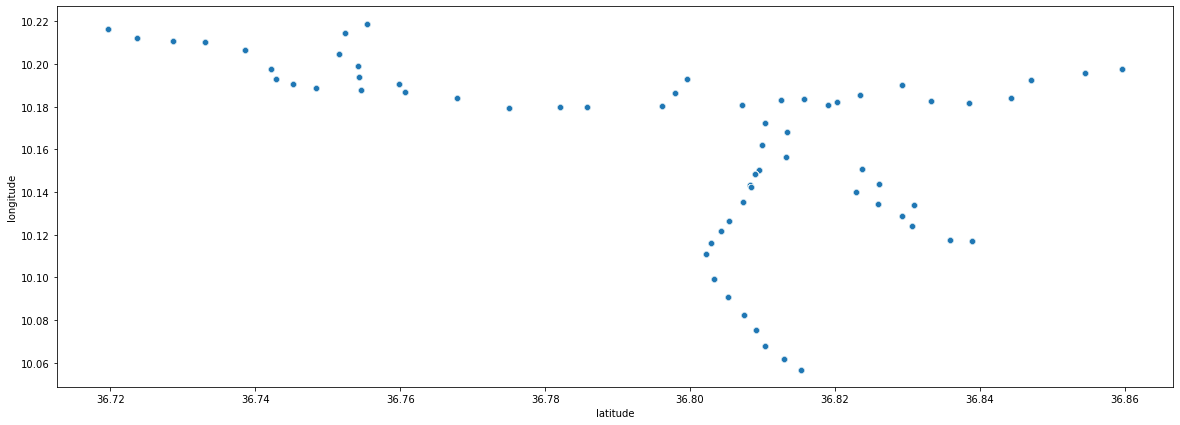

In [43]:
plt.figure(figsize= (20,7))
sns.scatterplot(data = metro.drop(['arrival_time','TripNb'], axis=1).drop_duplicates(), x='latitude', y='longitude')

## Bus

In [44]:
busstations = stations_paths[stations_paths.vehicle_type == 3].line_label.unique().tolist()
busstations

['104',
 '78',
 '4A',
 '32',
 '32B',
 '36',
 '79',
 '65',
 '36B',
 '43',
 '15',
 '15A',
 '15B',
 '12',
 '43B',
 '11']

In [45]:
#data from official Transtu website.
horaires_Bus = []
horaires_Bus.append(['104','05:50','06:50','18:15','19:10',40])
horaires_Bus.append(['36','08:00','07:30','17:40','18:10',80])
horaires_Bus.append(['43B','07:30','06:45','13:30','14:15',90])
horaires_Bus.append(['11','06:00','06:30','19:50','20:30',50])
horaires_Bus.append(['65','05:40','05:00','19:40','19:10',20])
horaires_Bus.append(['78','05:30','06:30','18:50','19:50',30])
horaires_Bus.append(['79','05:30','06:20','18:50','19:50',30])
horaires_Bus.append(['4A','04:10','04:40','23:00','23:30',40])
horaires_Bus.append(['12','04:15','05:45','22:40','23:30',40])
horaires_Bus.append(['15A','06:00','06:40','18:00','18:40',80])
horaires_Bus.append(['15B','06:10','06:50','19:30','20:10',80])
horaires_Bus.append(['15','06:20','07:00','18:50','19:40',80])
horaires_Bus.append(['32','03:10','04:40','22:45','23:15',20])
horaires_Bus.append(['32B','05:00','06:00','18:00','19:30',30])
horaires_Bus.append(['36B','08:30','08:00','-','17:25',0])
horaires_Bus.append(['43','09:00','-','14:20','-',40])

In [46]:
horaires_Bus = pd.DataFrame(horaires_Bus,columns=['line_label','premier_aller','premier_retour','dernier_aller','dernier_retour','frequence'])

In [47]:
horaires_Bus

,line_label,premier_aller,premier_retour,dernier_aller,dernier_retour,frequence
0,104,05:50,06:50,18:15,19:10,40
1,36,08:00,07:30,17:40,18:10,80
2,43B,07:30,06:45,13:30,14:15,90
3,11,06:00,06:30,19:50,20:30,50
4,65,05:40,05:00,19:40,19:10,20
5,78,05:30,06:30,18:50,19:50,30
6,79,05:30,06:20,18:50,19:50,30
7,4A,04:10,04:40,23:00,23:30,40
8,12,04:15,05:45,22:40,23:30,40
9,15A,06:00,06:40,18:00,18:40,80


In [48]:
#36B
horaires_Bus.iloc[14,3] = '16:45'
horaires_Bus.iloc[14,5] = 30

#43
horaires_Bus.iloc[15,2] = '08:00'
horaires_Bus.iloc[15,4] = '16:00'

In [49]:
bus_labels = gps[gps.line_id.isin(stations_paths[stations_paths.vehicle_type == 3].line_id)]\
             .merge(stations_paths[['line_id','tag','line_label']]\
             .groupby('line_id', as_index=False).first(), on  =['line_id'] )\
             .groupby('line_label_y').tag.count().index
bus_labels

Index(['104', '11', '12', '15', '15A', '15B', '32', '32B', '36', '36B', '43',
       '43B', '4A', '65', '78', '79'],
      dtype='object', name='line_label_y')

In [50]:
horaires_Bus = horaires_Bus[horaires_Bus.line_label.isin(bus_labels)]

In [51]:
Bus1 = pd.concat([horaires_Bus[['line_label','premier_aller','frequence']], horaires_Bus[['line_label','premier_retour','frequence']]], ignore_index=True, axis=0)
Bus2 = pd.concat([horaires_Bus[['line_label','dernier_aller']], horaires_Bus[['line_label','dernier_retour']]], ignore_index=True, axis=0)

In [52]:
Bus2.drop('line_label', axis = 1, inplace = True)

In [53]:
Bus = pd.concat([Bus1,Bus2], axis = 1)

In [54]:
n = int(Bus.shape[0]/2)
n

16

In [55]:
Bus['horaires'] = np.concatenate([Bus.iloc[:n].premier_aller.values , Bus.iloc[n:].premier_retour.values] , axis=0)

In [56]:
Bus['dernier_horaires'] = np.concatenate([Bus.iloc[:n].dernier_aller.values , Bus.iloc[n:].dernier_retour.values] , axis=0)

In [57]:
Bus['tag'] = np.concatenate([np.zeros(n),np.ones(n)*1], axis = 0)

In [58]:
Bus.drop(['premier_aller','premier_retour','dernier_aller','dernier_retour'], axis = 1, inplace=True)

In [59]:
Bus = Bus.merge(stations_paths[['line_label','tag','line_id']].groupby(['line_label','tag'], as_index=False).first(), on =['line_label','tag'])
Bus

,line_label,frequence,horaires,dernier_horaires,tag,line_id
0,104,40,05:50,18:15,0.0,4
1,36,80,08:00,17:40,0.0,26
2,43B,90,07:30,13:30,0.0,48
3,11,50,06:00,19:50,0.0,49
4,65,20,05:40,19:40,0.0,30
5,78,30,05:30,18:50,0.0,18
6,79,30,05:30,18:50,0.0,28
7,4A,40,04:10,23:00,0.0,20
8,12,40,04:15,22:40,0.0,41
9,15A,80,06:00,18:00,0.0,37


In [60]:
Bus.frequence = Bus.frequence*60

In [61]:
Bus.horaires = Bus.horaires.apply(lambda x : datetime.strptime('2000-1-1'+' '+x+':00', '%Y-%m-%d %H:%M:%S'))

In [62]:
Bus.dernier_horaires = Bus.dernier_horaires.apply(lambda x : datetime.strptime('2000-1-1'+' '+x+':00', '%Y-%m-%d %H:%M:%S'))

In [63]:
lines = []
record = {}
for line in Bus.values :
    #loop  = True
    print("line_id : ",line[-1])
    first = True
    while True :
        if first:
            lines.append([line[0],line[2],line[-2]])
            first = False
        else:
            if lines[-1][1] > line[3]:
                break
                print(line[2],' ',line[3])
            else : 
                time = lines[-1][1] + timedelta(0,line[1])
                lines.append([line[0],time,line[-2]])

line_id :  4
line_id :  26
line_id :  48
line_id :  49
line_id :  30
line_id :  18
line_id :  28
line_id :  20
line_id :  41
line_id :  37
line_id :  39
line_id :  35
line_id :  22
line_id :  23
line_id :  32
line_id :  34
line_id :  5
line_id :  27
line_id :  47
line_id :  50
line_id :  31
line_id :  19
line_id :  29
line_id :  21
line_id :  44
line_id :  38
line_id :  40
line_id :  36
line_id :  25
line_id :  24
line_id :  33


In [64]:
horaires_Bus = pd.DataFrame(lines, columns=['line_label','horaires','tag'])
horaires_Bus.horaires = horaires_Bus.horaires.dt.time.astype(str)
horaires_Bus.head()

,line_label,horaires,tag
0,104,05:50:00,0.0
1,104,06:30:00,0.0
2,104,07:10:00,0.0
3,104,07:50:00,0.0
4,104,08:30:00,0.0


In [65]:
horaires_Bus.shape

(716, 3)

In [66]:
#match line_label and tag with scheduled Trips
horaires_Bus = horaires_Bus.merge(stations_paths[['line_id','tag','line_label']].groupby('line_id', as_index=False).first(), on  =['line_label','tag'] ) 

In [67]:
#repeat lines to match number of stations for each path
Bus = pd.DataFrame(columns=horaires_Bus.columns)
for line_id in horaires_Bus.line_id.unique():
    nb_stations = stations_paths.query('line_id == '+str(line_id)).shape[0]
    Bus = Bus.append(horaires_Bus.loc[horaires_Bus[horaires_Bus.line_id == line_id].index.repeat(nb_stations)])

In [68]:
#increment order with respect to number of stations for each lines
Bus['order'] = Bus.groupby(['line_id','horaires']).cumcount()+1

In [69]:
#get the median time for each 2 consecutive stations in each line
line_ids = Bus.line_id.unique()
#here

deltatime_group = gps[(gps.line_id.isin(line_ids))].groupby(['line_id','order'],as_index=True).travel_time.median()
stoptime_group = gps[(gps.line_id.isin(line_ids))].groupby(['line_id','order'],as_index=True).stop_time.median()

Bus = Bus.merge(deltatime_group, on=['line_id','order'], how='left')
Bus = Bus.merge(stoptime_group, on=['line_id','order'], how='left')

Bus.horaires = Bus.horaires.apply(lambda x : datetime.strptime('2000-1-1'+' '+x, '%Y-%m-%d %H:%M:%S'))

In [70]:
Bus = Bus.dropna()

In [71]:
#increment time between stations
logtime = dict()
Bus.horaires = Bus.apply(lambda x : increment_time(*x), axis=1).dt.time

In [72]:
#add station coordinates
Bus = Bus.merge(stations_paths[['line_id','order','station_id','latitude','longitude']], on=['line_id','order'])

In [73]:
#add Trip Number
Bus = Bus.sort_values(['line_id','order'])
Bus['TripNb'] = Bus.groupby(['line_id','order']).cumcount()+1

In [74]:
Bus['departure_time'] = Bus[['horaires','stop_time']].apply(lambda x : add_departure_time(*x), axis=1)
Bus.rename({'horaires':'arrival_time'}, axis=1, inplace=True)

In [75]:
#sort values and delete microseconds
Bus.arrival_time = Bus.arrival_time.apply(lambda x : x.replace(x.hour,x.minute,x.second,0))
Bus.departure_time = Bus.departure_time.apply(lambda x : x.replace(x.hour,x.minute,x.second,0))

Bus = Bus.sort_values(['line_id', 'TripNb']).reset_index(drop = True)
Bus.head()

,line_label,arrival_time,tag,line_id,order,travel_time,stop_time,station_id,latitude,longitude,TripNb,departure_time
0,104,05:50:00,0.0,4,1,895.0,823.0,15,36.800174,10.190487,1,06:03:43
1,104,06:18:38,0.0,4,2,169.0,33.0,16,36.799103,10.186369,1,06:19:11
2,104,06:22:00,0.0,4,3,198.0,15.0,17,36.792631,10.185839,1,06:22:15
3,104,06:25:33,0.0,4,4,82.0,38.0,18,36.785595,10.179933,1,06:26:11
4,104,06:27:33,0.0,4,5,81.0,24.0,19,36.784376,10.175823,1,06:27:57


In [76]:
Bus.isnull().sum()

line_label        0
arrival_time      0
tag               0
line_id           0
order             0
travel_time       0
stop_time         0
station_id        0
latitude          0
longitude         0
TripNb            0
departure_time    0
dtype: int64

In [77]:
Bus.shape

(10783, 12)

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

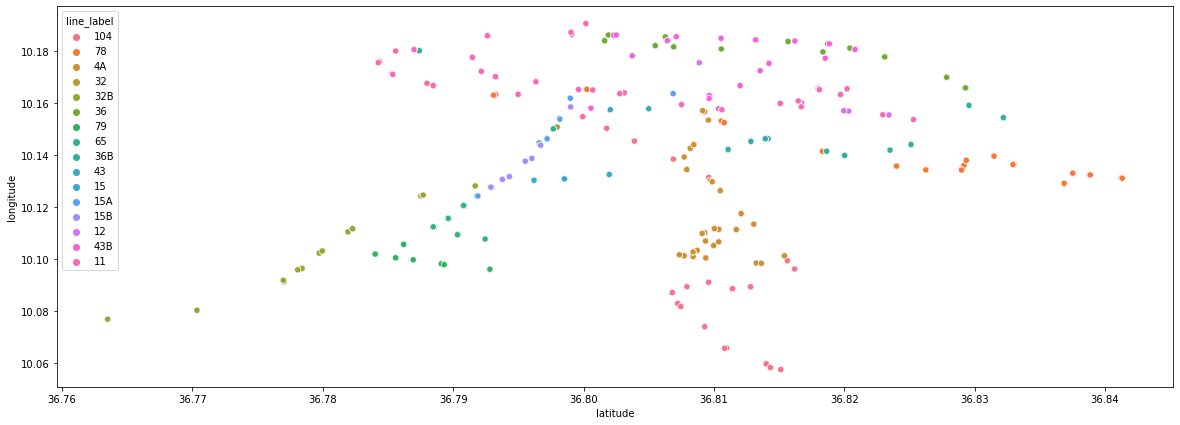

In [78]:
plt.figure(figsize= (20,7))
sns.scatterplot(data = Bus.drop(['arrival_time','TripNb'], axis=1).drop_duplicates(), x='latitude', y='longitude', hue = 'line_label')

# Time Table Extraction :

In [79]:
Bus[((Bus.departure_time.apply(lambda x : datetime.combine(datetime.min,x)) \
        - Bus.arrival_time.apply(lambda x : datetime.combine(datetime.min,x)) ).dt.total_seconds()<0)]

,line_label,arrival_time,tag,line_id,order,travel_time,stop_time,station_id,latitude,longitude,TripNb,departure_time


In [80]:
Bus.head()

,line_label,arrival_time,tag,line_id,order,travel_time,stop_time,station_id,latitude,longitude,TripNb,departure_time
0,104,05:50:00,0.0,4,1,895.0,823.0,15,36.800174,10.190487,1,06:03:43
1,104,06:18:38,0.0,4,2,169.0,33.0,16,36.799103,10.186369,1,06:19:11
2,104,06:22:00,0.0,4,3,198.0,15.0,17,36.792631,10.185839,1,06:22:15
3,104,06:25:33,0.0,4,4,82.0,38.0,18,36.785595,10.179933,1,06:26:11
4,104,06:27:33,0.0,4,5,81.0,24.0,19,36.784376,10.175823,1,06:27:57


In [81]:
metro[((metro.departure_time.apply(lambda x : datetime.combine(datetime.min,x)) \
        - metro.arrival_time.apply(lambda x : datetime.combine(datetime.min,x)) ).dt.total_seconds()<0)]

,line_label,arrival_time,tag,line_id,order,travel_time,stop_time,station_id,latitude,longitude,TripNb,departure_time
2995,5,23:59:29,0,3,14,NaN,189.5,1,36.838918,10.117072,107,00:02:38
13055,1,23:59:43,1,15,9,105.0,31.0,107,36.782100,10.179840,58,00:00:14


In [82]:
metro.head()

,line_label,arrival_time,tag,line_id,order,travel_time,stop_time,station_id,latitude,longitude,TripNb,departure_time
0,5,04:26:00,1,1,1,233.0,193.0,1,36.838918,10.117072,1,04:29:13
1,5,04:33:06,1,1,2,129.0,22.0,2,36.835840,10.117590,1,04:33:28
2,5,04:35:37,1,1,3,76.0,17.0,3,36.830582,10.124005,1,04:35:54
3,5,04:37:10,1,1,4,109.0,21.0,4,36.829180,10.128620,1,04:37:31
4,5,04:39:20,1,1,5,112.0,45.0,5,36.825880,10.134540,1,04:40:05


In [83]:
train[((train.departure_time.apply(lambda x : datetime.combine(datetime.min,x)) \
        - train.arrival_time.apply(lambda x : datetime.combine(datetime.min,x)) ).dt.total_seconds()<0)]

,line_label,arrival_time,tag,line_id,order,travel_time,stop_time,station_id,latitude,longitude,TripNb,departure_time
1157,TGM,23:59:52,0,10,6,68.0,14.0,77,36.828783,10.311553,65,00:00:06


In [84]:
train.head()

,line_label,arrival_time,tag,line_id,order,travel_time,stop_time,station_id,latitude,longitude,TripNb,departure_time
0,TGM,03:30:00,0,10,1,1046.0,361.0,72,36.800742,10.192478,1,03:36:01
1,TGM,03:53:27,0,10,2,114.0,15.0,73,36.814178,10.292450,1,03:53:42
2,TGM,03:55:36,0,10,3,68.0,16.0,74,36.818051,10.301940,1,03:55:52
3,TGM,03:57:00,0,10,4,85.0,17.0,75,36.819845,10.305601,1,03:57:17
4,TGM,03:58:42,0,10,5,54.0,16.0,76,36.824201,10.308773,1,03:58:58


In [85]:
timetable = pd.concat([train, metro, Bus], axis = 0)

In [86]:
#add vehicle type to timetable
timetable = timetable.merge(stations_paths.groupby('line_id').first().vehicle_type, how='left', on='line_id')

In [87]:
timetable = timetable.reset_index(drop=True)
timetable.shape

(29909, 13)

In [88]:
timetable.to_csv('data/timetable.csv')

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

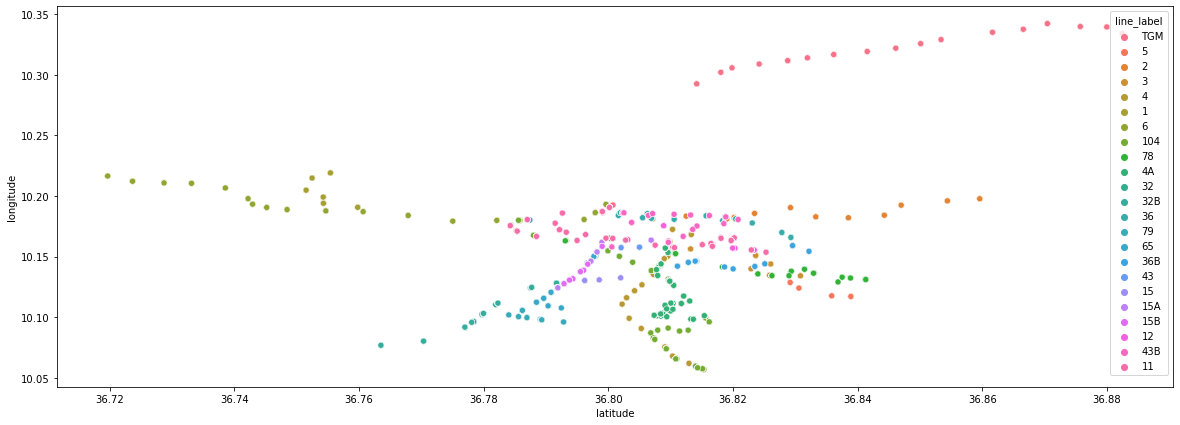

In [89]:
import seaborn as sns

plt.figure(figsize= (20,7))
sns.scatterplot(data = timetable.drop(['arrival_time','TripNb'], axis=1).drop_duplicates(), x='latitude', y='longitude', hue = 'line_label')

In [90]:
timetable

,line_label,arrival_time,tag,line_id,order,travel_time,stop_time,station_id,latitude,longitude,TripNb,departure_time,vehicle_type
0,TGM,03:30:00,0,10,1,1046.0,361.0,72,36.800742,10.192478,1,03:36:01,1
1,TGM,03:53:27,0,10,2,114.0,15.0,73,36.814178,10.292450,1,03:53:42,1
2,TGM,03:55:36,0,10,3,68.0,16.0,74,36.818051,10.301940,1,03:55:52,1
3,TGM,03:57:00,0,10,4,85.0,17.0,75,36.819845,10.305601,1,03:57:17,1
4,TGM,03:58:42,0,10,5,54.0,16.0,76,36.824201,10.308773,1,03:58:58,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29904,11,20:58:24,1.0,50,15,55.0,16.0,55,36.785375,10.170942,18,20:58:40,3
29905,11,20:59:35,1.0,50,16,143.0,16.0,252,36.784258,10.175475,18,20:59:51,3
29906,11,21:02:14,1.0,50,17,172.0,25.0,56,36.786997,10.180485,18,21:02:39,3
29907,11,21:05:31,1.0,50,18,197.0,36.0,17,36.792631,10.185839,18,21:06:07,3
